Por Pablo Fornet Martín

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import time as time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Function for loading data from a CSV file and returning the data and labels
def loadDataset(fileName, samples):
    x = []  # Array for data inputs
    y = []  # Array for labels (expected outputs)

    # Load data from a CSV file and store it in a pandas DataFrame object
    with open(fileName, 'r') as f:
        train_data = pd.read_csv(f)

    # Extract labels from the first column of the DataFrame object
    y = np.array(train_data.iloc[0:samples, 0])

    # Extract data from the remaining columns of the DataFrame object and normalize it
    x = np.array(train_data.iloc[0:samples, 1:]) / 255

    # Convert the data and labels to PyTorch tensors
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)

    # Return the data and labels
    return x, y

In [3]:
# Define a simple neural network class
class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        super(SimpleNeuralNetwork, self).__init__()

        # Define a fully connected layer with 784 input features (28x28 images) and 128 output features
        self.fc1 = nn.Linear(784, 50)

        # Define a fully connected layer with 128 input features and 10 output features (for the 10 digits)
        self.fc2 = nn.Linear(50, 10)

        self.fc3 = nn.Linear(5, 10)

        # Define the activation function as ReLU
        self.activation = nn.ReLU()

    def forward(self, x):
        # Flatten the input image into a 1D vector
        x = x.view(-1, 784)

        # Pass the input through the first fully connected layer and apply the activation function
        x = self.fc1(x)
        x = self.activation(x)

        # Pass the output of the first layer through the second fully connected layer
        x = self.fc2(x)
        # x = self.activation(x)

        # x = self.fc3(x)

        # Return the output
        return x


In [4]:
# Define the number of training and testing samples
trainingSamples = 20000
testingSamples = 10000

"""
Set global variables for the computing time of
both training and testing
"""
startTrainingTime = 0
endTrainingTime = 0
trainingTime = 0

startTestingTime = 0
endTestingTime = 0
testingTime = 0

In [5]:
# Load the training and testing datasets
train_x, train_y = loadDataset('MNIST\\mnist_train_small.csv', trainingSamples)
test_x, test_y = loadDataset('MNIST\\mnist_test.csv', testingSamples)

train_x = train_x[train_y != 9]
train_y = train_y[train_y != 9]

# Define the batch size for training and testing data
batchSize = 64

# Define a DataLoader object for the training data
train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=batchSize, shuffle=True)

# Define a DataLoader object for the testing data
test_loader = DataLoader(TensorDataset(test_x, test_y), batch_size=batchSize)

device = torch.device("cpu")  # remove to use GPU, is available
# Create a SimpleNeuralNetwork object and define the loss function and optimizer
model = SimpleNeuralNetwork().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Set the number of epochs for training
epochs = 20

In [6]:
# Train the model and measure the time
startTrainingTime = time.time()

# Loop over the specified number of epochs
for epoch in range(epochs):
    epoch_loss = 0.0
    epoch_accuracy = 0.0

    # Loop over the batches of training data
    for i, data in enumerate(train_loader):
        inputs, labels = data

        # Zero the gradients of the model parameters
        optimizer.zero_grad()

        # Forward pass through the model
        outputs = model(inputs)

        # Calculate the loss
        loss = loss_function(outputs, labels)

        # Backward pass through the model and update the parameters
        loss.backward()
        optimizer.step()

        # Update the epoch loss and accuracy
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        epoch_accuracy += correct / batchSize

    # Print out the epoch loss and accuracy
    print("Epoch:", epoch + 1, " Loss:", epoch_loss / len(train_loader), " Accuracy:",
            epoch_accuracy / len(train_loader))

endTrainingTime = time.time()
trainingTime = endTrainingTime - startTrainingTime

Epoch: 1  Loss: 0.6096611098250461  Accuracy: 0.8535920818505338
Epoch: 2  Loss: 0.2596842920493825  Accuracy: 0.926267793594306
Epoch: 3  Loss: 0.21327399678554823  Accuracy: 0.9406138790035588
Epoch: 4  Loss: 0.18176292396047786  Accuracy: 0.9489546263345195
Epoch: 5  Loss: 0.1603304761730373  Accuracy: 0.9554604092526691
Epoch: 6  Loss: 0.14432262306456253  Accuracy: 0.9594639679715302
Epoch: 7  Loss: 0.1286212526845126  Accuracy: 0.963133896797153
Epoch: 8  Loss: 0.11687513775593233  Accuracy: 0.9677491103202847
Epoch: 9  Loss: 0.10693180221016933  Accuracy: 0.9716970640569395
Epoch: 10  Loss: 0.09573179387298555  Accuracy: 0.9745885231316725
Epoch: 11  Loss: 0.08853073011805367  Accuracy: 0.9763122775800712
Epoch: 12  Loss: 0.08115221762174601  Accuracy: 0.978758896797153
Epoch: 13  Loss: 0.07425934765355337  Accuracy: 0.9799266014234875
Epoch: 14  Loss: 0.06810149993396156  Accuracy: 0.9820951957295374
Epoch: 15  Loss: 0.06151872039424567  Accuracy: 0.9850422597864769
Epoch: 16  

In [7]:
# Evaluate the model on the testing data and measure the time
certainty_distribution = np.zeros(len(test_y))
wrong_certainty_distribution = []
correct_certainty_distribution = []
predictions_matrix = np.zeros((10, 10))
nine_certainty_distribution = []

validResults = 0
startTestingTime = time.time()
for i in range(len(test_y)):
    inputs = test_x[i].unsqueeze(0)
    labels = torch.tensor([test_y[i]], dtype=torch.long)

    # Forward pass through the model
    outputs = model(inputs)

    softmax = nn.Softmax(dim=1)
    sm_outputs = softmax(outputs)
    certainty = torch.max(sm_outputs).item()

    _, predicted = torch.max(outputs.data, 1)
    result = predicted.item()
    expectedResult = int(labels[0])
    certainty_distribution[i] = certainty
    predictions_matrix[expectedResult, result] += 1

    if result == expectedResult:
        validResults = validResults + 1
        outcome = " OK "
        correct_certainty_distribution.append(certainty)
    else:
        outcome = "Fail"
        wrong_certainty_distribution.append(certainty)
        if expectedResult == 9:
            nine_certainty_distribution.append(certainty)

    print("Nº ", i + 1, " | Expected result: ", expectedResult, " | Obtained result: ", result, " | ", outcome,
            " | Certainty: ", round(torch.max(sm_outputs).item() * 100, 3),
            "%")

endTestingTime = time.time()
testingTime = endTestingTime - startTestingTime

wrong_certainty_distribution = np.array(wrong_certainty_distribution)
nine_certainty_distribution = np.array(nine_certainty_distribution)
correct_certainty_distribution = np.array(correct_certainty_distribution)

# Calculate and print out the training and testing time and the testing accuracy
print("-------------------------------")
print("Results")
print("-------------------------------")
print("Training samples: ", trainingSamples)
print("Training time: ", round(trainingTime, 2), " s")
print("Testing samples: ", testingSamples)
print("Testing time: ", round(testingTime, 2), " s")
print("Testing accuracy: ", round((validResults / testingSamples) * 100, 2), "%")

Nº  1  | Expected result:  7  | Obtained result:  7  |   OK   | Certainty:  99.867 %
Nº  2  | Expected result:  2  | Obtained result:  2  |   OK   | Certainty:  99.994 %
Nº  3  | Expected result:  1  | Obtained result:  1  |   OK   | Certainty:  97.864 %
Nº  4  | Expected result:  0  | Obtained result:  0  |   OK   | Certainty:  99.997 %
Nº  5  | Expected result:  4  | Obtained result:  4  |   OK   | Certainty:  99.963 %
Nº  6  | Expected result:  1  | Obtained result:  1  |   OK   | Certainty:  99.289 %
Nº  7  | Expected result:  4  | Obtained result:  4  |   OK   | Certainty:  99.515 %
Nº  8  | Expected result:  9  | Obtained result:  5  |  Fail  | Certainty:  90.634 %
Nº  9  | Expected result:  5  | Obtained result:  6  |  Fail  | Certainty:  99.412 %
Nº  10  | Expected result:  9  | Obtained result:  7  |  Fail  | Certainty:  57.154 %
Nº  11  | Expected result:  0  | Obtained result:  0  |   OK   | Certainty:  99.302 %
Nº  12  | Expected result:  6  | Obtained result:  6  |   OK   

Text(0, 0.5, 'Expected Label')

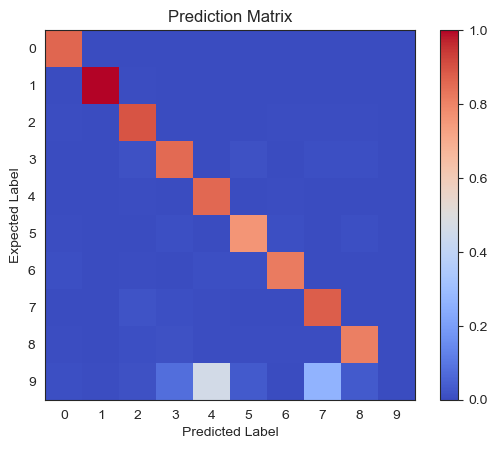

In [8]:
sns.set_style("white")
plt.title("Prediction Matrix")
plt.imshow(predictions_matrix/np.max(predictions_matrix), cmap='coolwarm')
plt.colorbar()
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.xlabel("Predicted Label")
plt.ylabel("Expected Label")

C:\Users\forne\AppData\Local\Temp\ipykernel_17392\3531179019.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(distributions[i], ax=ax)
C:\Users\forne\AppData\Local\Temp\ipykernel_17392\3531179019.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(distributions[i], ax=ax)
C:\Users\forne\AppDa

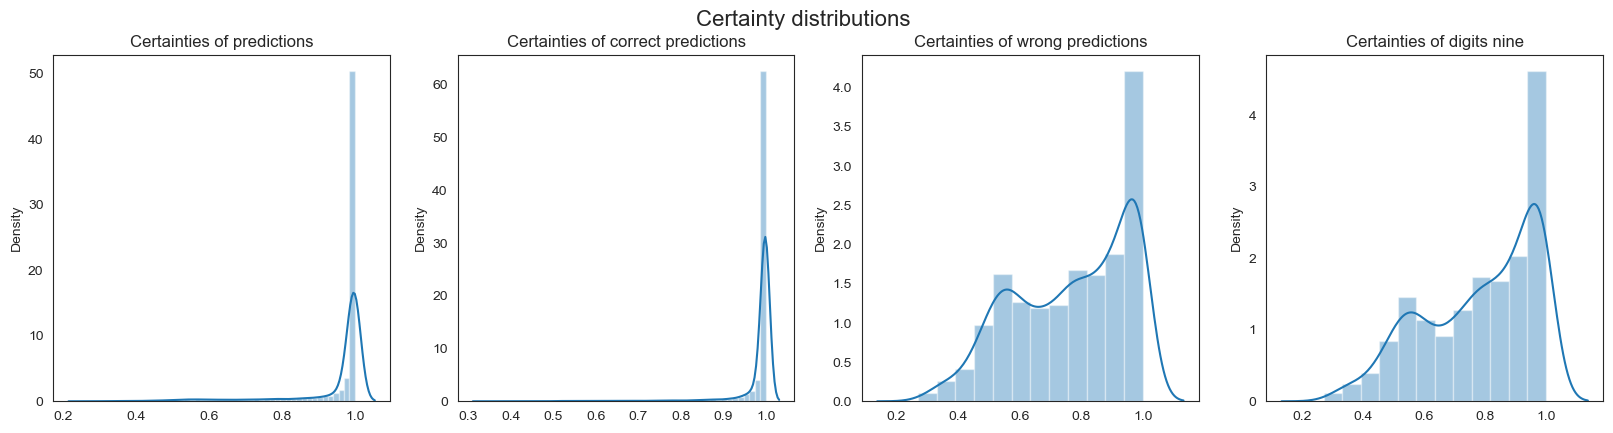

In [14]:
distributions = [certainty_distribution, correct_certainty_distribution, wrong_certainty_distribution, nine_certainty_distribution]
titles = ["Certainties of predictions", "Certainties of correct predictions","Certainties of wrong predictions", "Certainties of digits nine"]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 4.5))
fig.suptitle("Certainty distributions", fontsize=16)

for i, ax in enumerate(ax.flatten()):
    sns.distplot(distributions[i], ax=ax)
    ax.set_title(titles[i])